# Cell Type Prediction

There are different ways to predict cell types, e. g. using astir or argmax. Here, we demonstrate how to filter data and then use argmax to get a quick initial prediction.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spatial_data
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
xr.set_options(display_style='text')

In [3]:
ds = xr.load_dataset('/g/huber/projects/CITEseq/CODEX/BNHL_TMA/bhnl_labeled_zarr/166_4_I2_LK_labeled.zarr')

/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [4]:
# preprocessing: filtering by percentiles and applying a median filter

# can specify channel specific quanitle thresholds here (or even sample specific thresholds)
ct_dict = {
    "B": dict(channel = 'PAX5', quantile = .8, color=spatial_data.Red),
    "T": dict(channel = 'CD3', quantile = .5, color=spatial_data.Green),
    "Myeloid": dict(channel = 'CD11b', quantile = .8, color=spatial_data.Yellow),
    "Dendritic": dict(channel = 'CD11c', quantile = .8, color=spatial_data.Blue),
    "Granulo": dict(channel = 'CD15', quantile = .8, color=spatial_data.Apricot),
    "Macro": dict(channel = 'CD68', quantile = .8, color=spatial_data.Orange),
    "Stroma PDPN": dict(channel = 'Podoplanin', quantile = .95, color=spatial_data.Purple),
    "Stroma CD31": dict(channel = 'CD31', quantile = .95, color=spatial_data.Beige),
    "Stroma CD34": dict(channel = 'CD34', quantile = .95, color=spatial_data.Teal),
    "Stroma CD90": dict(channel = 'CD90', quantile = .95, color=spatial_data.Pink),
    "NK": dict(channel = 'CD56', quantile = .8, color=spatial_data.Brown),
}

channels = [ v['channel'] for k, v in  ct_dict.items()]
quantiles = [ v['quantile'] for k, v in  ct_dict.items()]
colors = [ v['color'] for k, v in  ct_dict.items()]

ds_processed = ds.pp[channels].pp.filter(quantiles).pp.restore('medfilt2d', kernel_size=3)

Text(0.5, 1.0, 'Processed')

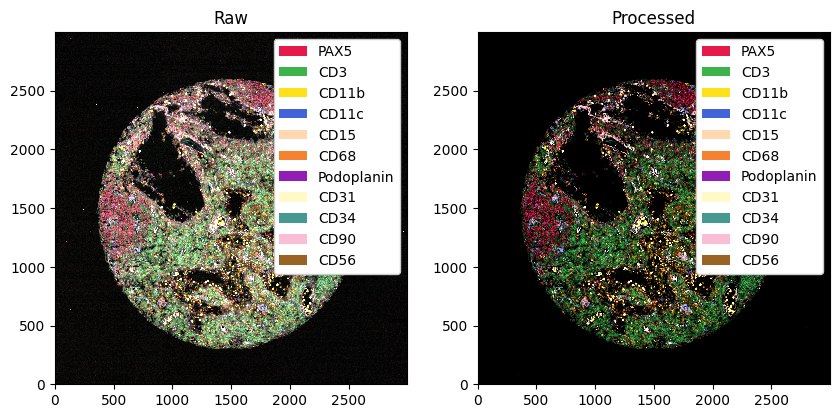

In [5]:
# plotting the ds and ds processed next to one another

# visualizing the raw vs the processed image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

_ = ds.pp[channels].pl.colorize(colors).pl.imshow(legend_background=True, ax=ax[0])
_ = ds_processed.pp[channels].pl.colorize(colors).pl.imshow(legend_background=True, ax=ax[1])

ax[0].set_title("Raw")
ax[1].set_title("Processed")

In [6]:
ct_marker_dict = dict(zip(ct_dict.keys(), channels))
ct_marker_dict

/g/huber/users/meyerben/notebooks/codex_analysis/2024-03-18_spatialproteomics_package/spatial-data/spatial_data/la/label.py:13: AccessorRegistrationWarning: registration of accessor <class 'spatial_data.la.label.LabelAccessor'> under name 'la' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class LabelAccessor:
/g/huber/users/meyerben/notebooks/codex_analysis/2024-03-18_spatialproteomics_package/spatial-data/spatial_data/pp/preprocessing.py:27: AccessorRegistrationWarning: registration of accessor <class 'spatial_data.pp.preprocessing.PreprocessingAccessor'> under name 'pp' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class PreprocessingAccessor:


{'B': 'PAX5',
 'T': 'CD3',
 'Myeloid': 'CD11b',
 'Dendritic': 'CD11c',
 'Granulo': 'CD15',
 'Macro': 'CD68',
 'Stroma PDPN': 'Podoplanin',
 'Stroma CD31': 'CD31',
 'Stroma CD34': 'CD34',
 'Stroma CD90': 'CD90',
 'NK': 'CD56'}

In [9]:
# predicting the cell type using the argmay
ds_with_ct_predictions = ds_processed.la.predict_cell_types_argmax(ct_marker_dict, key='_arcsinh_mean', overwrite_existing_labels=True)

# adding colors to match the markers
ct_color_dict = dict(zip(ct_dict.keys(), colors))
for k, v in ct_color_dict.items():
    ds_with_ct_predictions = ds_with_ct_predictions.la.set_label_color(k, v)

/g/huber/users/meyerben/notebooks/codex_analysis/2024-03-18_spatialproteomics_package/spatial-data/spatial_data/la/label.py:13: AccessorRegistrationWarning: registration of accessor <class 'spatial_data.la.label.LabelAccessor'> under name 'la' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class LabelAccessor:
Did not find Stroma PDPN.
Did not find Stroma CD31.


Text(0.5, 1.0, 'Cell Type Predictions')

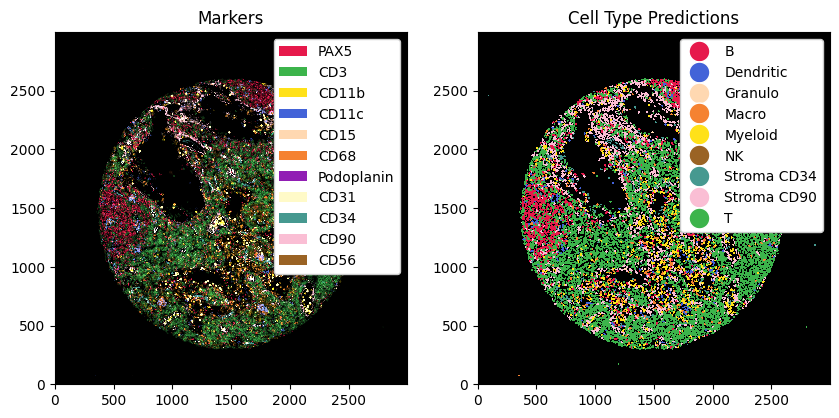

In [10]:
# plotting the ct predictions next to the processed image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

_ = ds_with_ct_predictions.pp[channels].pl.colorize(colors).pl.imshow(legend_background=True, ax=ax[0])
_ = ds_with_ct_predictions.pl.imshow(render_intensities=False, render_labels=True, legend_label=True, ax=ax[1])

ax[0].set_title("Markers")
ax[1].set_title("Cell Type Predictions")